In [25]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel.data import PanelData
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects, compare
import matplotlib.pyplot as plt
from plot_result import plot_result

In [26]:
df=pd.read_csv("../../data/merged/len3_ship_DN.csv",encoding="shift-jis",index_col=0)
# sum ver.
# df=pd.read_csv("../data/merged/len3_ship_sum_DN.csv",encoding="shift-jis",index_col=0)

Estimation

In [27]:
df.columns

Index(['year', 'id', 'efficacy', 'rx_dom', 'otc_dom', 'self_dom', 'stock_rx',
       'stock_otc', 'stock_self', 'stock_rx_lag', 'stock_otc_lag',
       'stock_self_lag', 'Approved', 'KEGG', 'Ingredient', 'date',
       'release_year', '成分', 'variable', 'elapsed', 'elapsed_m14',
       'elapsed_m13', 'elapsed_m12', 'elapsed_m11', 'elapsed_m10',
       'elapsed_m9', 'elapsed_m8', 'elapsed_m7', 'elapsed_m6', 'elapsed_m5',
       'elapsed_m4', 'elapsed_m3', 'elapsed_m2', 'elapsed_m1', 'elapsed_0',
       'elapsed_1', 'elapsed_2', 'elapsed_3', 'elapsed_4', 'elapsed_5',
       'elapsed_6', 'elapsed_7', 'elapsed_8', 'elapsed_9', 'elapsed_10',
       'elapsed_11', 'elapsed_12', 'elapsed_13', 'elapsed_14', 'elapsed_15',
       'elapsed_16', 'elapsed_17', 'elapsed_18', 'elapsed_19', 'elapsed_20',
       'elapsed_21', 'elapsed_22', 'elapsed_23', 'elapsed_24', 'elapsed_25',
       'elapsed_26', 'elapsed_27', 'elapsed_28', 'elapsed_29', 'elapsed_30',
       'elapsed_31', 'Year', 'generic_per', '薬効分

In [28]:
#前処理
df.replace('-',"0",inplace=True)
df["otc_dom"].replace(",","",regex=True,inplace=True)
df["rx_dom"].replace(",","",regex=True,inplace=True)
df["stock_otc_lag"].replace(",","",regex=True,inplace=True)
df["stock_rx_lag"].replace(",","",regex=True,inplace=True)
# fillna
df["otc_dom"].fillna(0,inplace=True)
df["rx_dom"].fillna(0,inplace=True)
df["stock_otc_lag"].fillna(0,inplace=True)
df["stock_rx_lag"].fillna(0,inplace=True)

df["otc_dom"]=df["otc_dom"].astype(int)
df["rx_dom"]=df["rx_dom"].astype(int)
df["stock_otc_lag"]=df["stock_otc_lag"].astype(int)
df["stock_rx_lag"]=df["stock_rx_lag"].astype(float)
#ここはかなり重要でセレクションバイアスみたいなので有意性が変わるらしい
df=df.loc[df["otc_dom"]>0]
df=df.loc[df["rx_dom"]>0]
# df=df.loc[df["stock_otc_lag"]>0]
# df=df.loc[df["stock_rx_lag"]>0]
# df=df.loc[df["generic_share_q"]>0]

In [29]:
# normalization of year
# 2008で正規化するかで結構estimateが変わります、1ぐらい
# df["year"]=df["year"]-2008

#ここはかなり重要でセレクションバイアスみたいなので有意性が変わるらしい
df=df.loc[df["otc_dom"]>0]
df=df.loc[df["rx_dom"]>0]
df=df.loc[df["self_dom"]>0]
# df=df.loc[df["generic_share_q"]>0]
df["nonself_dom"]=df["otc_dom"]-df["self_dom"]
# make log columns
df["log_rx_dom"]=np.log(df["rx_dom"])
df["log_otc_dom"]=np.log(df["otc_dom"])
df["log_self_dom"]=np.log(df["self_dom"])
df["log_nonself_dom"]=np.log(df["nonself_dom"]+1e-4) 
df["log_stock_rx_lag"]=np.log(df["stock_rx_lag"]+0.001)
df["log_stock_otc_lag"]=np.log(df["stock_otc_lag"]+0.001)

df=df.loc[df["otc_dom"]>0]
df=df.loc[df["rx_dom"]>0]
# df=df.loc[df["stock_otc_lag"]>0]
# df=df.loc[df["stock_rx_lag"]>0]
# df=df.loc[df["generic_share_q"]>0]
df=df.loc[df["year"]>2014]
df["year_trend"]=df["year"]-2015

In [30]:
df=df.set_index(["id","year"])
df.info()
# make this to paneldata
df=PanelData(df)
df.shape

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 113 entries, (114, 2015) to (799, 2021)
Columns: 102 entries, efficacy to year_trend
dtypes: float64(18), int32(3), int64(75), object(6)
memory usage: 90.1+ KB


(170, 7, 17)

stockのlag(むしろgeneric?)とtime effectは共存できないらしい

### OTC

In [31]:

# formula="otc_dom ~ year_trend+elapsed_m10+elapsed_m9+elapsed_m8+elapsed_m7+elapsed_m6+elapsed_m5+elapsed_m4+elapsed_m3+elapsed_m2+elapsed_0+elapsed_1+elapsed_2+elapsed_3+elapsed_4+elapsed_5+elapsed_6+elapsed_7+elapsed_8+elapsed_9+elapsed_10+elapsed_11+elapsed_12+elapsed_13+elapsed_14+elapsed_15+generic_per+TimeEffects+EntityEffects"
# # stock lag version
# # formula+="+stock_otc_lag"
# # gemeric_per
# formula+=" + generic_per"
# mod_fe=PanelOLS.from_formula(formula, data=df, drop_absorbed=True)
# # mod_fe=PanelOLS.from_formula(formula, data=df, drop_absorbed=False)
# res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
# print(res_fe.summary.tables[1])
# print(res_fe.summary.tables[0])
# plot_result(res_fe,file_name="otc",title="OTC",period=25,insert_index=9,time_start=-10)

                          PanelOLS Estimation Summary                           
Dep. Variable:        log_nonself_dom   R-squared:                        0.1939
Estimator:                   PanelOLS   R-squared (Between):              0.3244
No. Observations:                 113   R-squared (Within):               0.2210
Date:                Tue, Jan 23 2024   R-squared (Overall):              0.3281
Time:                        18:22:55   Log-likelihood                   -257.42
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.1123
Entities:                          17   P-value                           0.3601
Avg Obs:                       6.6471   Distribution:                   F(16,74)
Min Obs:                       1.0000                                           
Max Obs:                       7.0000   F-statistic (robust):         -2.206e+12
                            

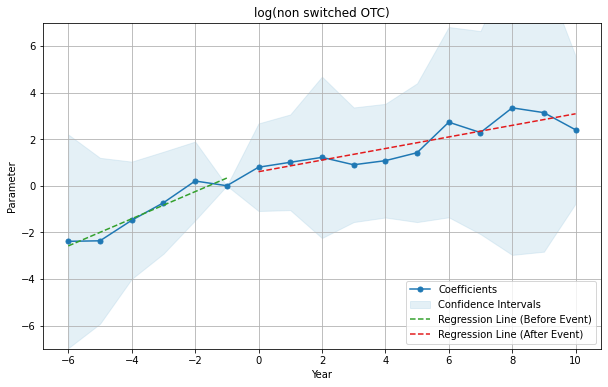

In [32]:
# take log
# formula="log_nonself_dom ~elapsed_m10+elapsed_m9+elapsed_m8+elapsed_m7+elapsed_m6+ elapsed_m5+elapsed_m4+elapsed_m3+elapsed_m2+elapsed_0+elapsed_1+elapsed_2+elapsed_3+elapsed_4+elapsed_5+elapsed_6+elapsed_7+elapsed_8+elapsed_9+elapsed_10+elapsed_11+elapsed_12+elapsed_13+elapsed_14+elapsed_15+generic_per+TimeEffects+EntityEffects"

# till 15
formula="log_nonself_dom ~elapsed_m6+elapsed_m5+elapsed_m4+elapsed_m3+elapsed_m2+elapsed_0+elapsed_1+elapsed_2+elapsed_3+elapsed_4+elapsed_5+elapsed_6+elapsed_7+elapsed_8+elapsed_9+elapsed_10+TimeEffects+EntityEffects"

# stock lag version
# formula+="+log_stock_otc_lag"

# year trend
# formula+="+year_trend"

# gemeric_per
# formula+=" + generic_per"

# generic_share_r
# formula+=" + generic_share_r"
# generic_share_q
# formula+=" + generic_share_q"
# formula+=" + log(generic_share_q)"


mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
# res_fe=mod_fe.fit()
# print(res_fe.summary.tables[1])
# print(res_fe.summary.tables[0])
print(res_fe)
plot_result(res_fe,file_name="nonself_log",title="log(non switched OTC)",ylim=(-7,7))

                          PanelOLS Estimation Summary                           
Dep. Variable:           log_self_dom   R-squared:                        0.1594
Estimator:                   PanelOLS   R-squared (Between):              0.0419
No. Observations:                 113   R-squared (Within):              -0.0626
Date:                Tue, Jan 23 2024   R-squared (Overall):              0.0422
Time:                        18:22:55   Log-likelihood                   -43.178
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.8771
Entities:                          17   P-value                           0.5968
Avg Obs:                       6.6471   Distribution:                   F(16,74)
Min Obs:                       1.0000                                           
Max Obs:                       7.0000   F-statistic (robust):          1.544e+14
                            

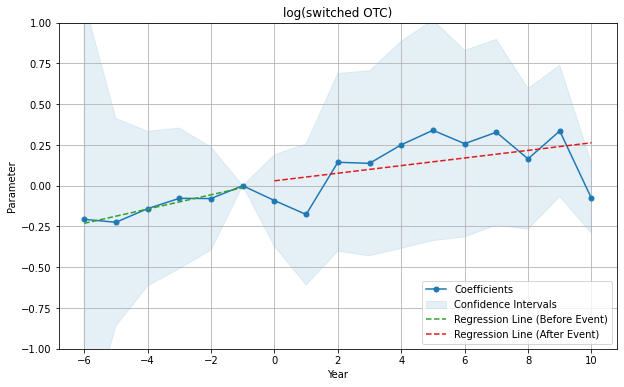

In [33]:
# take log
# formula="log_nonself_dom ~elapsed_m10+elapsed_m9+elapsed_m8+elapsed_m7+elapsed_m6+ elapsed_m5+elapsed_m4+elapsed_m3+elapsed_m2+elapsed_0+elapsed_1+elapsed_2+elapsed_3+elapsed_4+elapsed_5+elapsed_6+elapsed_7+elapsed_8+elapsed_9+elapsed_10+elapsed_11+elapsed_12+elapsed_13+elapsed_14+elapsed_15+generic_per+TimeEffects+EntityEffects"

# till 15
formula="log_self_dom ~elapsed_m6+elapsed_m5+elapsed_m4+elapsed_m3+elapsed_m2+elapsed_0+elapsed_1+elapsed_2+elapsed_3+elapsed_4+elapsed_5+elapsed_6+elapsed_7+elapsed_8+elapsed_9+elapsed_10+TimeEffects+EntityEffects"

# stock lag version
# formula+="+log_stock_otc_lag"

# year trend
# formula+="+year_trend"

# gemeric_per
# formula+=" + generic_per"

# generic_share_r
# formula+=" + generic_share_r"
# generic_share_q
# formula+=" + generic_share_q"
# formula+=" + log(generic_share_q)"


mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
# res_fe=mod_fe.fit()
# print(res_fe.summary.tables[1])
# print(res_fe.summary.tables[0])
print(res_fe)
plot_result(res_fe,file_name="self_log",title="log(switched OTC)")